In [3]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os

#thanks Muammar 
PAD_ix=-1

# Problem & Dataset

* We solve a problem of transribing english words.
* word (sequence of letters) -> transcipt (sequence of phonemes)
* The problem is, some letters correspond to several phonemes and others - to none.
* We solve it through encoder-decoder recurrent neural networks
* This architecture is generally about converting ANY sequence into ANY other sequence. It could even become president one day.

In [2]:
with open("./train.csv") as fin:
    ids,words,transcripts = zip(*[line.split(',') for line in list(fin)[1:]])
    words = [word+"@" for word in words]
    transcripts = [["START"]+ts[:-2].split()+["END"] for ts in transcripts]

In [3]:
phonemes = list(set([token for ts in transcripts for token in ts]))
phoneme_to_ix = {ph:i for i,ph in enumerate(phonemes)}

In [4]:
letters = list(set([token for word in words for token in word]))
letter_to_ix = {l:i for i,l in enumerate(letters)}

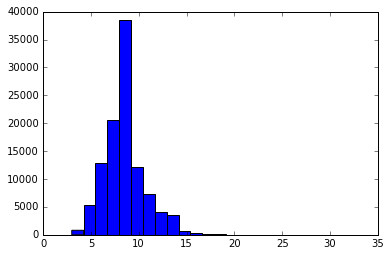

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(map(len,transcripts),bins=25);

# truncate names longer than MAX_LEN characters. 
MAX_LEN = min([60,max(list(map(len,transcripts)))])
#ADJUST IF YOU ARE UP TO SOMETHING SERIOUS


### Cast everything from symbols into matrix of int32. Pad with -1

In [6]:
def as_matrix(sequences,token_to_i, max_len=None,PAX_ix=PAD_ix):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int8') -1
    for i,seq in enumerate(sequences):
        row_ix = map(token_to_i.get,seq)[:max_len]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix


In [ ]:
print as_matrix(words[:10],letter_to_ix)

# Input variables

In [7]:
input_sequence = T.matrix('token sequence','int32')
target_phonemes = T.matrix('target phonemes','int32')


# Build NN

You will be building a model that takes token sequence and predicts next token


* iput sequence
* one-hot / embedding
* recurrent layer(s)
* otput layer(s) that predict output probabilities


In [8]:
from lasagne.layers import InputLayer,DenseLayer,EmbeddingLayer
from lasagne.layers import RecurrentLayer,LSTMLayer,GRULayer,CustomRecurrentLayer

In [9]:

##ENCODER
l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)
l_mask = lasagne.layers.InputLayer(shape=(None, None),input_var=T.neq(input_sequence,-1))
l_emb = lasagne.layers.EmbeddingLayer(l_in, len(letters), 40)
l_rnn = lasagne.layers.GRULayer(l_emb,256,only_return_final=True,mask_input=l_mask)

##DECODER
transc_in = lasagne.layers.InputLayer(shape=(None, None),input_var=target_phonemes)
transc_mask = lasagne.layers.InputLayer(shape=(None, None),input_var=T.neq(target_phonemes,-1))
transc_emb = lasagne.layers.EmbeddingLayer(transc_in, len(phonemes), 50)
transc_rnn = lasagne.layers.GRULayer(transc_emb,256,hid_init=l_rnn,mask_input=transc_mask)


#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
transc_rnn_flat = lasagne.layers.reshape(transc_rnn, (-1,transc_rnn.output_shape[-1]))

l_out = lasagne.layers.DenseLayer(transc_rnn_flat,len(phonemes),nonlinearity=lasagne.nonlinearities.softmax)



In [10]:
# Model weights
weights = lasagne.layers.get_all_params(l_out,trainable=True)
print weights

[W, W, W_in_to_updategate, W_hid_to_updategate, b_updategate, W_in_to_resetgate, W_hid_to_resetgate, b_resetgate, W_in_to_hidden_update, W_hid_to_hidden_update, b_hidden_update, W_in_to_updategate, W_hid_to_updategate, b_updategate, W_in_to_resetgate, W_hid_to_resetgate, b_resetgate, W_in_to_hidden_update, W_hid_to_hidden_update, b_hidden_update, W, b]


In [11]:
network_output = lasagne.layers.get_output(l_out)
network_output = <reshape to [batch_i, time_tick, number_of_phonemes] symbolically> 
#If you use dropout do not forget to create deterministic version for evaluation

In [12]:
predictions_flat = network_output[:,:-1,:].reshape([-1,len(phonemes)])
targets = target_phonemes[:,1:].ravel()

#do not count loss for '-1' tokens
mask = T.nonzero(T.neq(targets,-1))

loss = T.nnet.categorical_crossentropy(predictions[mask],targets[mask])


updates = lasagne.updates.adam(loss.mean(),weights)

# Compiling it

In [13]:

#training
train = theano.function([input_sequence, target_phonemes], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_phonemes], loss, allow_input_downcast=True)


# generation

Simple: 
* get initial context(seed), 
* predict next token probabilities,
* sample next token, 
* add it to the context
* repeat from step 2

You'll get a more detailed info on how it works in the homework section.

In [14]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
network_output = network_output.reshape((target_phonemes.shape[0],target_phonemes.shape[1],len(phonemes)))
#predictions for next tokens (after sequence end)
last_word_probas = network_output[:,-1]
probs = theano.function([input_sequence,target_phonemes],last_word_probas,allow_input_downcast=True)


In [15]:
def generate_transcript(word,transcript_prefix = ("START",),t=1,sample=True):
    
    transcript = list(transcript_prefix)
    while True:
        next_phoneme_probs = probs(as_matrix([word],letter_to_ix),as_matrix([transcript],phoneme_to_ix) ).ravel()
        next_phoneme_probs = next_phoneme_probs**t / np.sum(next_phoneme_probs**t)

        if sample:
            next_phoneme = np.random.choice(phonemes,p=next_phoneme_probs) 
        else:
            next_phoneme = phonemes[np.argmax(next_phoneme_probs)]

        transcript.append(next_phoneme)

        if next_phoneme=="END":
            break
    return transcript

# Model training

Here you can tweak parameters or insert your generation function


__Once something word-like starts generating, try increasing seq_length__



# Умная мысля 2
Имеет смысл не брать случайные слова, а сэмплить более качественно
1) перемешаем номера примеров
2) проходим по первым 100(batch_size) примерам, потом по вторым 100 ... и так до конца выборки

повторять до победы

In [16]:
words = np.array(words)
transcripts = np.array(transcripts)

In [17]:
def sample_batch(words,transcripts, batch_size):
    
    batch_ix = np.random.randint(0,len(words),size=batch_size)
    words_batch=as_matrix(words[batch_ix],letter_to_ix) 
    transcripts_batch=as_matrix(transcripts[batch_ix],phoneme_to_ix)
    return words_batch,transcripts_batch

In [19]:

!pip install tqdm
from tqdm import tqdm

In [21]:


print("Training ...")


#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=10


for epoch in range(n_epochs):


    avg_cost = 0;
    
    for _ in tqdm(range(batches_per_epoch)):
        
        x,y = sample_batch(words,transcripts,batch_size)
        avg_cost += train(x, y).mean()
        
        
    
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))
    for i in range(5):
        ind = np.random.randint(len(words))
        print words[ind],':', ' '.join(generate_transcript(words[ind],sample=False)[1:-1])



  0%|          | 1/500 [00:00<01:27,  5.73it/s]

Training ...


100%|██████████| 500/500 [00:49<00:00, 10.02it/s]


Epoch 0 average loss = 1.85032779562
ARCADIANS@ : R AA K T IH N AH L
COPSEY@ : K AA S T IY
DEVRY@ : D IH D ER
SPINOFFS@ :

  0%|          | 1/500 [00:00<00:51,  9.69it/s]

 S P IH NG K AH S
REVELING@ : R IH Z IH NG L AH N


100%|██████████| 500/500 [00:50<00:00,  8.44it/s]


Epoch 1 average loss = 1.45303875083
BENNARDO@ : B EH N D AO R D
APHRODISIAC@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 AE K R IH F IH K T IH Z
BRONZE@ : B R AE N Z
NAPROSYN@ : N AE D R AH M AH N
WYNETTE@ : W IH N T


100%|██████████| 500/500 [00:55<00:00,  9.09it/s]


Epoch 2 average loss = 1.21868729433
DESMITH@ : D IH S K AA D
WATERMAN@ : W UH D ER M AH N
ELLY@ : EH L IY
REGULATED@ :

  0%|          | 1/500 [00:00<00:50,  9.98it/s]

 R IY G L AH D IH NG
SADISM@ : S AE D Z IH M


100%|██████████| 500/500 [00:49<00:00, 10.02it/s]


Epoch 3 average loss = 1.09711241991
SANDWICH@ : S AE N D IY F
SPOTLIGHTING@ : S P AA L T IH G AH N T
PERMITTED@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 P ER M IH T IH D
LOVLER@ : L OW V ER
DADDY'S@ : D AA D IY Z


100%|██████████| 500/500 [00:52<00:00,  9.44it/s]


Epoch 4 average loss = 0.975313797031
BLACKS'@ : B L AE K S
MAKEOVERS@ : M AH K EY T ER Z
EVIN@ : EY V IH N
BUTTER@ : B AH T ER
GALERIES@ :

  0%|          | 1/500 [00:00<01:00,  8.19it/s]

 G AA L R IY Z


100%|██████████| 500/500 [00:51<00:00,  8.83it/s]


Epoch 5 average loss = 0.890361384073
PAMPER@ : P AE M P ER
TABLECLOTHS@ : T AE B L AH K L EY T S
TUINSTRA@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 T IH N T R AE K T
DRAKEFORD@ : D R AE K F ER D
PANACO@ : P AE N AH K OW


100%|██████████| 500/500 [00:50<00:00,  9.93it/s]


Epoch 6 average loss = 0.810319096288
OUTMANNED@ : AW T M AH N D
VOELKER@ : V AA L ER K
CESAR@ : S EH K ER
AUGENSTEIN@ :

  0%|          | 1/500 [00:00<00:52,  9.42it/s]

 AH JH IH N S T IY N
POLITICS'@ : P OW L IY T IH S


100%|██████████| 500/500 [00:50<00:00,  8.63it/s]


Epoch 7 average loss = 0.756217607067
TOTEMS@ : T AH T IH M Z
CREWES@ : K R IY Z
HRIVNAK@ : R IH N T AH K
PROJECTS@ : P R AH T EH K T S
TOTING@ :

  0%|          | 1/500 [00:00<01:10,  7.06it/s]

 T AH T IH NG


100%|██████████| 500/500 [00:52<00:00,  7.85it/s]


Epoch 8 average loss = 0.701356052742
INTERLAKE'S@ : IH N ER AH L AH S
KWEISI@ : K W IY S IY
NATURALIZES@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 N AA T ER W AA L AH S
DELICACY@ : D IH L IH K S IY
ULCERATION@ : AH L K ER SH AH N


100%|██████████| 500/500 [00:57<00:00, 10.09it/s]


Epoch 9 average loss = 0.653565513083
RUDENESS@ : R AH D AH N Z
ARGOT@ : AA R G AH T
SHOWCASE@ : SH OW K AH S
MONTH'S@ : M AA D AH Z
CORRECTIVE@ :

  0%|          | 1/500 [00:00<00:55,  9.03it/s]

 K AO R AH S T IH V


100%|██████████| 500/500 [00:53<00:00, 10.10it/s]


Epoch 10 average loss = 0.6332418567
VARS@ : V ER Z
CREMATE@ : K R EH M EY T
COUNSELLORS@ : K AW N S L ER Z
MAURICE'S@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 M AO R IH S IH Z
BERGER'S@ : B ER G ER Z


100%|██████████| 500/500 [00:54<00:00,  7.89it/s]


Epoch 11 average loss = 0.603553995531
IACOCCA@ : Y UW K AA S AH
WHACKO@ : HH AA K OW
SUSTEREN@ : S AH S T ER N
DWI@ : D IY
DELIVERED@ :

  0%|          | 1/500 [00:00<01:00,  8.20it/s]

 D EH L IH V ER D


100%|██████████| 500/500 [00:54<00:00,  7.99it/s]


Epoch 12 average loss = 0.576738259877
GAMEKEEPERS@ : G AE M IH K T ER Z
ATTRIBUTION@ : AE T R IH B Y UW EY SH AH N
DEVIATES@ : D EH V IY AH T S
NONVIOLENT@ : N AA N V IY AH L EY T
CONGRESSWOMEN@ :

  0%|          | 1/500 [00:00<01:27,  5.68it/s]

 K AA NG G R AH S F IH L M AH N


100%|██████████| 500/500 [00:59<00:00,  8.80it/s]


Epoch 13 average loss = 0.548812184544
TERRILE@ : T EH R AH L
FLEMINGS@ : F L EH M IH NG Z
MULTIFACET@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 M AH L F AH K EY T
SHOWIEST@ : SH AW Y UW IH T S
OSTIN@ : AA S T IH N


100%|██████████| 500/500 [00:59<00:00,  6.75it/s]


Epoch 14 average loss = 0.540459259586
HYPERBOLE@ : HH AY P ER B AH L
GATELY@ : G EY T L IY
PASSERBY@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 P AE S ER B IY
WASS@ : W AA S
QUERIDA@ : K W EH R IY D AH


100%|██████████| 500/500 [01:05<00:00,  7.82it/s]


Epoch 15 average loss = 0.522364331682
ORCHID@ : AO R CH IH D
OXYGEN@ : AA K S AY JH AH N
CREMATION@ : K R AH M EY SH AH N
SATANISM@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 S AE T AH N IH Z AH M
PACKAGED@ : P AE K AH JH D


100%|██████████| 500/500 [01:05<00:00,  8.01it/s]


Epoch 16 average loss = 0.50158768009
LOWLAND@ : L OW L AH N D
RAPPORT@ : R AE P AO R T
MEDITATE@ : M EH D IH T EY T
KIRLIN@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 K ER L IH N
KOVALYOV@ : K AH V AA L Y UW V


100%|██████████| 500/500 [01:05<00:00,  7.80it/s]


Epoch 17 average loss = 0.481419608221
DEFERENTIAL@ : D IH F ER EH N SH AH L
MASAO@ : M AA S OW
VYING@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 V AY IH NG
BOTSFORD@ : B AA S T F ER D
CLOKE@ : K L OW K


100%|██████████| 500/500 [01:05<00:00,  7.74it/s]


Epoch 18 average loss = 0.468051512583
STUNNING@ : S T AH N IH NG
HEAPING@ : HH IY P IH NG
BOY'S@ : B OY Z
BOEPPLE@ : B OW P AH L
BART'S@ :

  0%|          | 1/500 [00:00<01:12,  6.84it/s]

 B AA R T S


100%|██████████| 500/500 [01:05<00:00,  7.34it/s]


Epoch 19 average loss = 0.464308446173
MAGRO@ : M AA G R OW
BILE@ : B AY L
RIEBEL@ : R IY B AH L
DEMONSTRATE@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 D IH M AA N S T R EY T
EMBOLISMS@ : IH M B OW L IH N S


100%|██████████| 500/500 [01:05<00:00, 10.12it/s]


Epoch 20 average loss = 0.437489812585
FINED@ : F AY N D
SLOGGING@ : S L AA G IH NG
CERRONE@ : S ER OW N
PUGLIA@ : P AH G L IY AH
ALITALIA@ :

  0%|          | 1/500 [00:00<00:50,  9.94it/s]

 AE L AH T AA L IY AH


100%|██████████| 500/500 [00:58<00:00,  5.51it/s]


Epoch 21 average loss = 0.436624642774
CLUMSILY@ : K L AH M S L IY
GONNERMAN@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 G AA N ER M AH N
HODDUR@ : HH AA D ER
ADISQ@ : AA D IH S
GIVENS'S@ : G IH V AH N Z IH Z


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 22 average loss = 0.432119545415
TAPERED@ : T AE P ER D
BATZEL@ : B AE T AH L
ABLES@ : AE B AH L Z
BEJAR@ : B IY G ER
AZALEAS@ : AH Z AE L AH Z


100%|██████████| 500/500 [01:03<00:00,  7.43it/s]


Epoch 23 average loss = 0.419587944947
DESULTORY@ : D IH S AH L T ER IY
GOETTING@ : G OW T IH NG
REHA@ : R IY HH AH
SIFERS@ :

  0%|          | 1/500 [00:00<00:52,  9.45it/s]

 S AY F ER Z
DESTRUCTS@ : D IH S T R AH K T S


100%|██████████| 500/500 [00:58<00:00,  8.97it/s]


Epoch 24 average loss = 0.407202749115
CONGEAL@ : K AA N JH AH L
SHARPIE@ : SH AA R P IY
NITRIC@ : N IH T R IH K
TELFAIR@ :

  0%|          | 1/500 [00:00<00:52,  9.43it/s]

 T EH L F EY ER
CLUTTERING@ : K L AH T ER IH NG


100%|██████████| 500/500 [00:58<00:00,  9.10it/s]


Epoch 25 average loss = 0.403361211304
NEESE@ : N IY Z
WOLFINGER@ : W AO L F IH NG ER
ANAMARIA@ : AH N AE M ER IY AH
EXAMPLE@ :

  0%|          | 1/500 [00:00<01:10,  7.12it/s]

 IH G Z AE M P AH L
ILIANO@ : IH L IY AA N OW


100%|██████████| 500/500 [00:56<00:00,  7.97it/s]


Epoch 26 average loss = 0.410129525203
BENTZ@ : B EH N T S
HULING@ : HH AH L IH NG
SEMIANNUAL@ : S EH M AH N EY SH AH N
WALESA'S@ : W AA L EY Z AH Z
UNECONOMIC@ :

  0%|          | 1/500 [00:00<01:27,  5.71it/s]

 AH N EH K AH N AH M IH K


100%|██████████| 500/500 [01:07<00:00,  6.99it/s]


Epoch 27 average loss = 0.392760082644
NIMRODI@ : N IH M R OW D IY
ECONOMICALLY@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 EH K AH N OW M IH K L IY
BRANCH@ : B R AE N CH
PECAN@ : P EH K AH N
GARNISH@ : G AA R N IH SH


100%|██████████| 500/500 [04:04<00:00,  6.41it/s]


Epoch 28 average loss = 0.406933505808
OTHMAN'S@ : AH TH M AH N Z
REVEALS@ : R IY V AH L Z
KIENAST@ : K IY N AH S T
STEIB@ : S T AY B
ANNALS@ :

  0%|          | 1/500 [00:00<00:58,  8.59it/s]

 AE N AH L Z


100%|██████████| 500/500 [01:01<00:00,  7.59it/s]


Epoch 29 average loss = 0.37660758284
FINGERPRINTED@ : F IH NG G ER P ER IH N T
ZISA@ : Z IY S AH
PARRINO@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 P AA R IY N OW
BROMFIELD@ : B R AA M F IY L D
BUONOMO@ : B UW AA N OW M OW


100%|██████████| 500/500 [00:59<00:00,  8.81it/s]


Epoch 30 average loss = 0.376193572726
MECHANICS@ : M EH CH AH N IH K S
STALCUP@ : S T AE L K AH P
SANCHEZ@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 S AE N CH IH Z
FLAVIA@ : F L AA V IY AH
PITFALL@ : P IH T F AH L


100%|██████████| 500/500 [01:10<00:00,  6.68it/s]


Epoch 31 average loss = 0.373149381957
MINDED@ : M IH N D IH D
WATTLED@ : W AA T AH L D
JOVITA@ : JH OW V IY T AH
HOUDEK@ : HH AW D EH K
BOARDINGS@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 B AO R D IH NG Z


100%|██████████| 500/500 [01:14<00:00,  5.82it/s]


Epoch 32 average loss = 0.373371990309
RELAPSED@ : R IY L AE P S T
GEMAYEL@ : JH EH M EY L
BREAN@ : B R IY N
DUVAL@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 D UW V AH L
VASKE@ : V AE S K


100%|██████████| 500/500 [01:09<00:00,  8.59it/s]


Epoch 33 average loss = 0.375202999539
TOPKNOT@ : T AA P N AH T
LONSDALE@ : L AA N Z D EY L
COZ@ : K AO Z
SOMEWHERE@ :

  0%|          | 1/500 [00:00<01:02,  8.05it/s]

 S AA M Y ER W EH
LIDS@ : L IH D Z


100%|██████████| 500/500 [01:06<00:00,  5.27it/s]


Epoch 34 average loss = 0.360430071535
AEROFLOT@ : EH R OW F L AA T
FEMALE'S@ : F EH M AH L Z
MARZULLO@ : M AA R Z UW L OW
HERBALISTS'@ : HH ER B AH L AE S T S
VANHOOK@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 V AE N D HH OW K


100%|██████████| 500/500 [01:06<00:00,  7.57it/s]


Epoch 35 average loss = 0.354016243782
PLASTICS@ : P L AE S T IH K S
SKYROCKETED@ : S K AY R K AH K T IH D
ROLLBACKS@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 R OW L B AE K S
FILOSA@ : F IH L OW S AH
ACCORDS@ : AH K AO R D Z


100%|██████████| 500/500 [00:59<00:00,  8.37it/s]


Epoch 36 average loss = 0.342721439155
ARMOIRES@ : AA R M OY ER Z
REABSORB@ : R IY B Z AO R B
ALLEGHENY'S@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 AE L AH G IY N Z
CHRONICLING@ : K R AA N IH K L IH NG
JURAN@ : Y UH R AH N


100%|██████████| 500/500 [01:00<00:00,  7.94it/s]


Epoch 37 average loss = 0.348222596537
DORRELL@ : D AO R AH L
WINDSORS@ : W IH N S ER Z
RAZA@ : R AA Z AH
STAMPFLI@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 S T AE M P L UW
KNACKS@ : N AE K S


100%|██████████| 500/500 [01:14<00:00,  6.91it/s]


Epoch 38 average loss = 0.343827152263
VIDEOTAPE@ : V AY D IY OW T EY P
KENDALL'S@ : K EH N D AH L Z
CRISPINA@ : K R IH S P IY N AH
STAHLY@ : S T AE L IY
GRACE@ :

  0%|          | 1/500 [00:00<01:22,  6.06it/s]

 G R EY S


100%|██████████| 500/500 [01:07<00:00,  8.22it/s]


Epoch 39 average loss = 0.327642299501
CABEZAS@ : K AA B EH Z AH Z
MULTIPLIES@ : M AH L T AH P L IY Z
BUCHNER@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 B AH K N ER
SCOVILLE@ : S K AA V IH L
CAVIAR@ : K AE V IY AA R


100%|██████████| 500/500 [01:04<00:00,  7.99it/s]


Epoch 40 average loss = 0.337996256996
CLAYBAUGH@ : K EY B AO B
KNOY@ : N EY
NAQUIN@ : N AE K W IH N
PADULA@ : P AA D UW L AH
CORSA@ :

  0%|          | 1/500 [00:00<01:32,  5.38it/s]

 K AO R S AH


100%|██████████| 500/500 [01:07<00:00,  8.06it/s]


Epoch 41 average loss = 0.33862787641
UNREMITTING@ : AH N R EH M AH T IH NG
ROSENBERG@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 R OW Z AH N B ER G
MOERTEL@ : M AO R T EH L
ARMY@ : AA R M IY
BOLDIN@ : B OW L D IH N


100%|██████████| 500/500 [01:14<00:00,  7.28it/s]


Epoch 42 average loss = 0.343539751706
OPINING@ : OW P AY N IH NG
SOMBERLY@ : S AA M B ER L IY
FULCHER@ : F AH L CH ER
LEOTARD@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 L EH T ER D
AMBRIANO@ : AE M B R IY AA N OW


100%|██████████| 500/500 [01:10<00:00,  6.55it/s]


Epoch 43 average loss = 0.319555494121
REASSERT@ : R IY S ER T
TEMPLES@ : T EH M P AH L Z
RYCKMAN@ :

  0%|          | 1/500 [00:00<00:58,  8.57it/s]

 R IH K M AH N
BELTED@ : B EH L T IH D
CHIMED@ : CH AY M EH D


100%|██████████| 500/500 [01:14<00:00,  7.98it/s]


Epoch 44 average loss = 0.335268925729
NONBANK@ : N AA N B AE NG K
ROLEN@ : R OW L AH N
WITKOWSKI@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 V IH CH K AO F S K IY
INTERACCIONES@ : IH N T ER SH EY N IY AH S
KEARNY@ : K ER N IY


100%|██████████| 500/500 [01:18<00:00,  5.52it/s]


Epoch 45 average loss = 0.311253242568
BECKWORTH'S@ : B EH K W ER TH S
BURGETT@ : B ER G IH T
CRITCHFIELD@ :

  0%|          | 1/500 [00:00<01:02,  7.97it/s]

 K R IH CH F IY L D
LIMA@ : L IY M AH
LAVIS@ : L AE V IH S


100%|██████████| 500/500 [01:16<00:00,  8.27it/s]


Epoch 46 average loss = 0.326997609321
MANIK@ : M AE N IH K
NARDIELLO@ : N AA R D IY OW L IY
MARV@ : M AA R V
METAMORPHASIS@ :

  0%|          | 1/500 [00:00<00:54,  9.12it/s]

 M EH T AH M AO R F AH S
DUCOMMUN@ : D UW K AH M AH N


100%|██████████| 500/500 [01:16<00:00,  7.44it/s]


Epoch 47 average loss = 0.322882707045
LACH@ : L AE K
KRAS@ : K R AE S
SOLILOQUY@ : S OW L IY L AO F S K IY
FER@ : F ER
STARTLED@ :

  0%|          | 1/500 [00:00<01:19,  6.29it/s]

 S T AA R T AH L D


100%|██████████| 500/500 [01:20<00:00,  6.47it/s]


Epoch 48 average loss = 0.320240893905
SLATING@ : S L EY T IH NG
WHEELABRATOR@ : W IY L B AE G R OW ER
NETSCAPE'S@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 N EH T S K EY P S
ENVISIONS@ : EH N V IH ZH AH N Z
PIPPIN@ : P IH P IH N


100%|██████████| 500/500 [01:17<00:00,  6.88it/s]


Epoch 49 average loss = 0.317581123317
PRUNEDALE@ : P R AH N EH N D AH L
POSNER@ : P OW Z N ER
MISCONCEIVES@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 M IH S K AH N S IY V Z
BURMANS@ : B ER M AH N Z
ABABA@ : AE B AA B AH


100%|██████████| 500/500 [01:18<00:00,  6.35it/s]


Epoch 50 average loss = 0.302075089708
SALEMA@ : S AH L EH M AH
ISOLATIONIST@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 AY Z AH L AA SH AH N AH S T
RICKER@ : R IH K ER
EPOCHAL@ : EH P AH K AH L
ROSEMARIE@ : R OW Z M EH R IY


100%|██████████| 500/500 [10:48<00:00,  7.57it/s]


Epoch 51 average loss = 0.295608515621
DONG@ : D AO NG
GELASIA@ : JH AH L EY S IY AH
WASIELEWSKI@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 W IH Z IH L EH S K IY
MIRAGES@ : M IH R AA JH IH Z
DONAPRIA@ : D OW N AA P R IY AH


100%|██████████| 500/500 [01:08<00:00,  7.49it/s]


Epoch 52 average loss = 0.300899188301
SHAKE@ : SH EY K
WHOPPERS@ : W AA P ER Z
BARTHOLOMEW@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 B AA R TH L AH M EH L OW
SATIN@ : S AE T AH N
MORAVEK@ : M ER AA V IH K


100%|██████████| 500/500 [01:11<00:00,  7.55it/s]


Epoch 53 average loss = 0.301607186366
HAUPTMANN@ : HH AW S T M AH N
PALLA@ : P AA L AH
VOICEWORKS@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 V OY S W ER K S
TECHNICIANS@ : T EH K N IH SH AH N Z
DUKAKIS@ : D UW K AA K IH S


100%|██████████| 500/500 [01:12<00:00,  6.19it/s]


Epoch 54 average loss = 0.305996314698
TURQUOISE@ : T ER K W EY S
SALAMANDER@ : S AE L AH M AE N D ER
FURLETT@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 F ER L IH T
PROFOUNDLY@ : P R OW F AW N D L IY
WRANGLER@ : R AE NG G L ER


100%|██████████| 500/500 [01:17<00:00,  6.83it/s]


Epoch 55 average loss = 0.300120091243
BRIEFEST@ : B R IY F AH S T
UPHELD@ : AH P HH EH L D
EVOLVING@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 IY V OW L V IH NG
DISTILLER@ : D IH S T IH L ER
REXFORD@ : R EH K S F ER D


100%|██████████| 500/500 [01:11<00:00,  7.11it/s]


Epoch 56 average loss = 0.294179919385
YEARLINGS@ : Y ER L IH NG Z
LEGENDS@ : L EH JH AH N D Z
CARNEGIE-MELLON@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 K AA R N AH G IY M Y AH N
VASLEV@ : V AE S L IH V
PRELIM@ : P R IY L IH M


100%|██████████| 500/500 [01:14<00:00,  7.42it/s]


Epoch 57 average loss = 0.290535109171
UNSUCCESSFULLY@ : AH N S AH K S EH F L IH K
CURFMAN@ : K ER F M AH N
OVERSTAYED@ : OW V ER S T EY D
LENNING@ : L EH N IH NG
MACDONALD'S@ :

  0%|          | 1/500 [00:00<01:30,  5.54it/s]

 M AH K D AA N AH L D Z


100%|██████████| 500/500 [01:11<00:00,  5.40it/s]


Epoch 58 average loss = 0.285303843769
BOOTHMAN@ : B UW TH M AH N
SCIENCES@ : S AY AH N S IH Z
ENGLAND@ : EH NG G L AH N D
CALL'S@ : K AO L Z
REAGANISM@ :

  0%|          | 1/500 [00:00<01:28,  5.65it/s]

 R IY G AH N IH Z AH M


100%|██████████| 500/500 [01:13<00:00,  6.35it/s]


Epoch 59 average loss = 0.288997708697
MUGFORD@ : M AH G F ER D
COASTAMERICA'S@ : K OW S T AA M IH R IH K AH Z
CHELLIS@ : CH EH L IH S
FOUNDATIONAL@ :

  0%|          | 1/500 [00:00<00:54,  9.08it/s]

 F AW N D EY SH AH N AH L
SEUSS@ : S UW Z


100%|██████████| 500/500 [01:13<00:00,  7.58it/s]


Epoch 60 average loss = 0.287127518531
EZEKIEL@ : EH Z IH K IY L
ZIPPERED@ : Z IH P ER D
FIREPLACE@ : F AY R P L EY S
HOST'S@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 HH OW S T S
RECHARGEABLE@ : R IY K AA R D AH G AH L


100%|██████████| 500/500 [01:14<00:00,  7.25it/s]


Epoch 61 average loss = 0.28804871018
CYRIL@ : S IH R AH L
YAHOO@ : Y UW HH UW
LEVENSTEIN@ : L EH V AH N S T IY N
WITHEY@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 W IH DH IY
VALUELESS@ : V AE L Y UW L AH S


100%|██████████| 500/500 [01:11<00:00,  7.20it/s]


Epoch 62 average loss = 0.283787412582
TUMBLE@ : T AH M B AH L
DEERING@ : D IY IH R IH NG
PALEO@ : P AE L IY OW
CROMBIE@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 K R AA M B IY
NEWMARKET@ : N UW M AA R K AH T


100%|██████████| 500/500 [01:12<00:00,  6.82it/s]


Epoch 63 average loss = 0.275332091687
STUDIO@ : S T UW D IY OW
CLENCHER@ : K L EH N CH ER
MCGRAIL@ : M AH G R EY L
BEAM@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 B IY M
KASINGA'S@ : K AH S IH NG G AH Z


100%|██████████| 500/500 [01:11<00:00,  6.48it/s]


Epoch 64 average loss = 0.279376495017
BERMUDEZ@ : B ER M Y UW D IY Z
ASHUR@ : AE SH ER
LARAMEE@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 L ER AA M IY
DEFIANTLY@ : D IH F AY AH N T L IY
RAGE@ : R EY JH


100%|██████████| 500/500 [01:13<00:00,  5.95it/s]


Epoch 65 average loss = 0.289224858362
PEACEMAKERS@ : P IY S M EY K ER Z
RECOGNIZING@ : R IY K AH N JH AY Z IH NG
BERRINGER@ : B EH R IH NG ER
LIVELIHOODS@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 L AY V L AY HH UH D Z
MUSIDORA@ : M UW S IY D AO R AH


100%|██████████| 500/500 [01:11<00:00,  5.33it/s]


Epoch 66 average loss = 0.283921765955
ELEVATING@ : EH L AH V EY T IH NG
FILIPSKI@ : F IH L IH P S K IY
MAINFRAMES@ : M EY N F R EY M Z
STOCKING@ : S T AA K IH NG
CASTRONOVA@ :

  0%|          | 1/500 [00:00<01:06,  7.53it/s]

 K AE S T R AA N OW V AH


100%|██████████| 500/500 [01:15<00:00,  7.99it/s]


Epoch 67 average loss = 0.281914813533
OUST@ : AW S T
CELIA@ : CH EH L IY AH
PRESCHOOLER@ : P R IY SH UW L ER
HORRENDOUSLY@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 HH AO R IH N D UW AH L IY
WEISGERBER@ : W AY S G ER B ER


100%|██████████| 500/500 [01:11<00:00,  7.38it/s]


Epoch 68 average loss = 0.280580399977
LION'S@ : L AY AH N Z
ROHLEDER@ : R OW L IH D ER
GOODY'S@ : G UH D IY Z
GARUDA@ :

  0%|          | 1/500 [00:00<00:57,  8.73it/s]

 G AA R UW D AH
ALTHEA@ : AA L TH IY AH


100%|██████████| 500/500 [01:11<00:00,  5.96it/s]


Epoch 69 average loss = 0.276969778035
EXTIRPATING@ : EH K S T R AH P T IH NG
ANYWAY@ : AE N W EY
BARRYMORE@ : B AA R IH M AO R
STAMPING@ : S T AE M P IH NG
BECKON@ :

  0%|          | 1/500 [00:00<01:02,  8.05it/s]

 B EH K AA N


100%|██████████| 500/500 [01:11<00:00,  6.31it/s]


Epoch 70 average loss = 0.270715494252
STATED@ : S T EY T IH D
TANKARD@ : T AE NG K ER D
PRANK@ : P R AE NG K
NESTED@ :

  0%|          | 1/500 [00:00<01:11,  6.99it/s]

 N EH S T IH D
KMIEC@ : K IY M IY


100%|██████████| 500/500 [01:12<00:00,  8.07it/s]


Epoch 71 average loss = 0.265665310511
GRIMMEST@ : G R IH M AH S T
POPPEA@ : P AA P IY AH
HUGHY@ : HH Y UW IY
DUBROVNIK@ :

  0%|          | 1/500 [00:00<01:15,  6.59it/s]

 D UW B R AA V IH N S
LUHR@ : L ER


100%|██████████| 500/500 [01:13<00:00,  7.75it/s]


Epoch 72 average loss = 0.276116964468
AMERICA'S@ : AH M EH R IH K AH Z
SALEEBY@ : S AE L AH B IY
SCHNEBERGER@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 SH N IH B ER G ER
ILLEGALS@ : IH L IH G AH L Z
FEUD@ : F Y UW D


100%|██████████| 500/500 [01:10<00:00,  7.80it/s]


Epoch 73 average loss = 0.265763744328
DUBCEK@ : D UW B K EH K
JUNKER@ : JH AH NG K ER
STIGMATA@ : S T IH G M AA T AH
GORGONE@ :

  0%|          | 1/500 [00:00<00:58,  8.58it/s]

 G AO R G OW N
OLYMPIA@ : OW L IH M P IY AH


100%|██████████| 500/500 [01:08<00:00,  7.37it/s]


Epoch 74 average loss = 0.256874876554
BRIGHTLY@ : B R AY T L IY
DELFAVERO@ : D EH L F EH V ER OW
WINNETT@ : W IH N IH T
TRANSPARENTLY@ :

  0%|          | 1/500 [00:00<00:59,  8.39it/s]

 T R AE N S P EH T R AH N T L IY
MULLOY@ : M AH L OY


100%|██████████| 500/500 [01:14<00:00,  6.99it/s]


Epoch 75 average loss = 0.2616760703
SEGLER@ : S EH G L ER
MIDCENTURY@ : M IH D S EH N CH ER IY
SCHRONCE@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 SH R AA N S
TRESTER@ : T R EH S T ER
HARLEY'S@ : HH AA R L IY Z


100%|██████████| 500/500 [01:13<00:00,  7.54it/s]


Epoch 76 average loss = 0.26248513388
MARLOW@ : M AA R L OW
REPRESENTATIVE@ : R EH P R AH Z EH N T AH T IH V
NUNNERY@ : N AH N ER IY
INJUNCTIVE@ : IH N JH AH N T IH V
TALKIN@ :

  0%|          | 1/500 [00:00<01:19,  6.27it/s]

 T AE L K IH N


100%|██████████| 500/500 [01:17<00:00,  7.83it/s]


Epoch 77 average loss = 0.265154319964
ARMORIES@ : AA R M AO R IY Z
CUSIANA@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 K Y UW S IY AA N AH
DORSEY@ : D AO R S IY
BLONDE@ : B L AA N D
WARRING@ : W AO R IH NG


100%|██████████| 500/500 [01:13<00:00,  7.70it/s]


Epoch 78 average loss = 0.262841415715
SENIOR@ : S IY N Y ER
DISCOVERIES@ : D IH S K AH V EH R IY Z
ZENA@ : Z IY N AH
HAILS@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 HH EY L Z
SHAWLER@ : SH AO L ER


100%|██████████| 500/500 [01:13<00:00,  6.18it/s]


Epoch 79 average loss = 0.256985732393
GETTER@ : G EH T ER
CAROLYNE@ : K EH R AH L AY N
HALLET@ : HH AE L IH T
HANBACK@ : HH AE N B AE K
AMPLICONS@ :

  0%|          | 1/500 [00:00<01:01,  8.14it/s]

 AE M P L IH K AH N Z


100%|██████████| 500/500 [01:13<00:00,  5.62it/s]


Epoch 80 average loss = 0.257872068802
PENICILLIN@ : P EH N IH S IH L AH N
PLUE@ : P L UW
FLOOD@ : F L AH D
MENCHACA@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 M EH N CH AA K AH
DOCKED@ : D AA K T


100%|██████████| 500/500 [01:13<00:00,  8.17it/s]


Epoch 81 average loss = 0.257216483759
GERMANN@ : JH ER M AH N
AEROSMITH'S@ : EH R OW S M IH TH S
BARLOON@ : B AA R L UW N
YARD'S@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 Y AA R D Z
UNDERPERFORM@ : AH N D ER P ER F AO R M


100%|██████████| 500/500 [01:14<00:00,  6.60it/s]


Epoch 82 average loss = 0.250964413849
USAGES@ : Y UW Z EY JH IH Z
BEITEL@ : B AY T AH L
CLYVE@ : K L AY V
SELINAS@ :

  0%|          | 1/500 [00:00<01:00,  8.29it/s]

 S EH L IH N AH S
GAEBEL@ : G IY B AH L


100%|██████████| 500/500 [01:13<00:00,  7.45it/s]


Epoch 83 average loss = 0.250518244056
BRAKING@ : B R EY K IH NG
SASHES@ : S AE SH IH Z
FREVERT@ : F R EH V ER T

  0%|          | 0/500 [00:00<?, ?it/s]


OARSMAN@ : AO R S M AH N
O'HAGAN@ : OW HH EY G AH N


100%|██████████| 500/500 [01:09<00:00,  6.47it/s]


Epoch 84 average loss = 0.249471373616
HOLLOMON@ : HH AA L AH M AA N
BODI@ : B OW D IY
SCHAMEL@ : SH AE M AH L
SAPHIRA@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 S AH F IH R AH
LOFLIN@ : L AA F L IH N


100%|██████████| 500/500 [01:09<00:00,  7.95it/s]


Epoch 85 average loss = 0.25488150906
BUNCHE@ : B AH N CH
FLYTRAP@ : F L AY T R AE P
GARAFOLA@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 G AE R AH F OW L AH
CHALET@ : SH AE L IH T
ACKNOWLEDGE@ : AE K N OW L IH JH


100%|██████████| 500/500 [01:10<00:00,  7.29it/s]


Epoch 86 average loss = 0.249983579873
SUHM@ : S AH M
FAIRGROUND@ : F EH R G R AW N D
RECOVERABLE@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 R IH K AH V ER AH B AH L
MANEUVERABLE@ : M AH N UW V ER AH B AH L
SWAP@ : S W AA P


100%|██████████| 500/500 [01:17<00:00,  6.66it/s]


Epoch 87 average loss = 0.254636187308
WORSENED@ : W ER S AH N D
NEWGATEWAY@ : N UW G EY SH W EY
FERRELL@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 F EH R AH L
HOLICK@ : HH AA L IH K
APPLICATORS@ : AE P L AH K EY T ER Z


100%|██████████| 500/500 [01:14<00:00,  5.79it/s]


Epoch 88 average loss = 0.25079064946
RAUNCHY@ : R AO N CH IY
MURAVICH@ : M ER AA V IH CH
UNEASILY@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 AH N IY Z L IY
GUILD'S@ : G IH L D Z
PRETENDER@ : P R IH T EH N D ER


100%|██████████| 500/500 [01:15<00:00,  6.67it/s]


Epoch 89 average loss = 0.251593202713
KLUS@ : K L AH S
BEHELER@ : B EH HH IH L ER
OSTLING@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 AA S L IH NG
REFRESH@ : R IH F R EH SH
COONAN@ : K UW AA N


100%|██████████| 500/500 [01:12<00:00,  6.76it/s]


Epoch 90 average loss = 0.246506598994
ROLLEY@ : R AA L IY
FIORINA@ : F IY AO R IY N AH
LAMETA@ : L AH M EY T AH
BUFFERIN@ : B AH F ER IH N
DEWINTER@ :

  0%|          | 1/500 [00:00<00:55,  9.02it/s]

 D UW IH N T ER


100%|██████████| 500/500 [01:10<00:00,  6.56it/s]


Epoch 91 average loss = 0.238303082314
FACILITATE@ : F AH S IH L AH T EY T
SWEERS@ : S W IH R Z
LONA@ : L OW N AH
BREASTPLATE@ :

  0%|          | 1/500 [00:00<00:52,  9.43it/s]

 B R EH S P L AH T
KATES@ : K EY T S


100%|██████████| 500/500 [01:13<00:00,  7.16it/s]


Epoch 92 average loss = 0.258278775897
MANDRAKE@ : M AE N D R EY K
BACKBITING@ : B AE K B AY T IH NG
VISITORS'@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 V IH Z IH T ER Z
ILLUSIONIST'S@ : IH L UW ZH AH N AH S T S
PETRI@ : P EH T R IY


100%|██████████| 500/500 [01:12<00:00,  6.99it/s]


Epoch 93 average loss = 0.247166348545
REDEMPTIVE@ : R IY D EH M P T IH V
GIORGI@ : JH AO R JH IY
CASCADED@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 K AE S K AH D IH D
PAGERS@ : P EY JH ER Z
SKIPPING@ : S K IH P IH NG


100%|██████████| 500/500 [01:13<00:00,  6.22it/s]


Epoch 94 average loss = 0.235321529014
BRUMETT@ : B R UW M IH T
LIBERALIZED@ : L IH B ER AH L AY Z D
EYESORE@ : AY S AO R
HOFFENBERG@ : HH AO F AH N B ER G
BIGFOOT@ :

  0%|          | 1/500 [00:00<01:37,  5.13it/s]

 B IH G F UH T


100%|██████████| 500/500 [01:11<00:00,  7.21it/s]


Epoch 95 average loss = 0.239411711293
CHAPDELAINE@ : SH AE P T IH L EY N
UNDENIABLY@ : AH N D IY N Y AH B L IY
STARGATE@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 S T AA R G EY T
SHEEK@ : SH IY K
VALOIS@ : V AH L OY Z


100%|██████████| 500/500 [01:12<00:00,  6.49it/s]


Epoch 96 average loss = 0.237825497285
PERMISSIBLE@ : P ER M IH S AH B AH L
PRIVILEGE@ : P R IH V L IH JH
PTOLEMY@ : T OW L AH M IY
NONRECURRING@ : N AA N R IY K ER IH NG
LACIVITA@ :

  0%|          | 1/500 [00:00<01:14,  6.71it/s]

 L AA CH IY V IY T AH


100%|██████████| 500/500 [01:14<00:00,  6.71it/s]


Epoch 97 average loss = 0.246788730379
BULEMIC@ : B Y UW L IH M IH K
VEES@ : V IY Z
PROJECTING@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 P R AH JH EH K T IH NG
REJECTED@ : R IY JH EH K T AH D
SONDAG@ : S AA N D AE G


100%|██████████| 500/500 [01:12<00:00,  7.14it/s]


Epoch 98 average loss = 0.240498744685
GIORGIO@ : JH AO R JH OW
KRIEGEL@ : K R IY G AH L
SALINGERS@ :

  0%|          | 0/500 [00:00<?, ?it/s]

 S AE L IH NG ER Z
JURA@ : JH UH R AH
FENDRICK@ : F EH N D R IH K


100%|██████████| 500/500 [01:15<00:00,  5.04it/s]


Epoch 99 average loss = 0.241516589257
MINICOMPUTERS@ : M IH N IH K AH M P Y UW T ER Z
POSTERS@ : P OW S T ER Z
LANTING'S@ : L AE N T IH NG Z
FRATANGELO@ : F R AA T AA N G OW L OW
LEONARDI@ : L IY AH N AO R D IY


# And now,
* try lstm/gru
* try several layers
* try mtg cards
* try your own dataset of any kind